# Arbol de decisión

Se crea un arbol de decisón basandonos en las caracteristicas de la red neuronal

In [782]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.preprocessing import StandardScaler
import random
import ast

In [783]:
# Semilla
seed = random.randint(0, 1000)
print(f"Semilla: {seed}")

Semilla: 119


In [784]:
def paint_results(y_test, y_pred, order = True):
  # Grafica de la predicción y la realidad
  linespace = np.linspace(0, 1, y_pred.size)
  if order:
    # Ordena los pares test pred para que se vean mejor
    y_test, y_pred = zip(*sorted(zip(y_test, y_pred)))

  plt.plot(linespace, y_test, label="Real", marker="o")
  plt.plot(linespace, y_pred, label="Predicción", marker="x")
  plt.legend()
  plt.title("Real vs Predicción")
  plt.show()
  
def paint_real_vs_pred(y_test, y_pred):
  # Grafica de la predicción y la realidad
  plt.scatter(y_test, y_pred, marker="o")
  plt.xlabel("Real")
  plt.ylabel("Predicción")
  plt.title("Real vs Predicción")
  plt.show()
  # linealidad
  pearson = pearsonr(y_test, y_pred)[0]
  spearman = spearmanr(y_test, y_pred)[0]
  print(f"Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")

Mean Absolute Error:  0.10810864296590941
R2:  0.23401656316929098


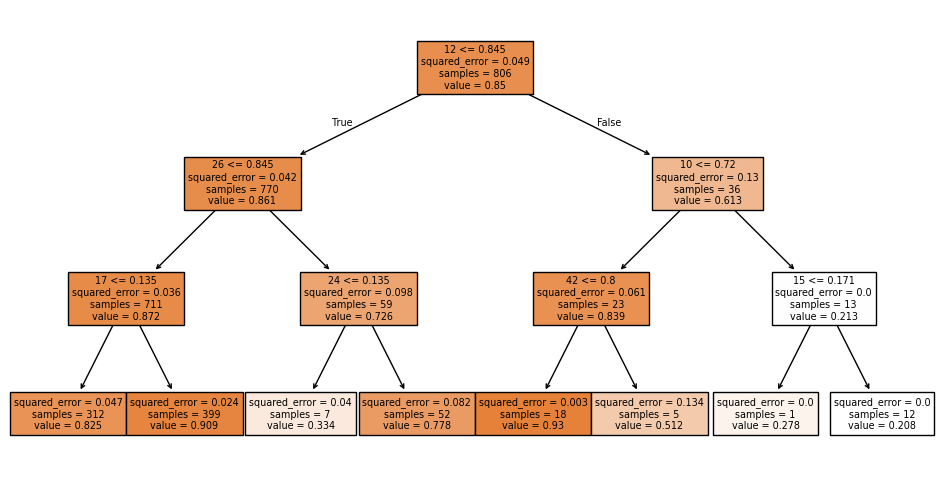

In [785]:
# lee el df
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar arbol
model = DecisionTreeRegressor(random_state=seed, max_depth=3)
regressor = model.fit(X_train, y_train)

# Predecir
y_pred = regressor.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 6))
plot_tree(regressor, feature_names=X.columns, filled=True)
plt.show()

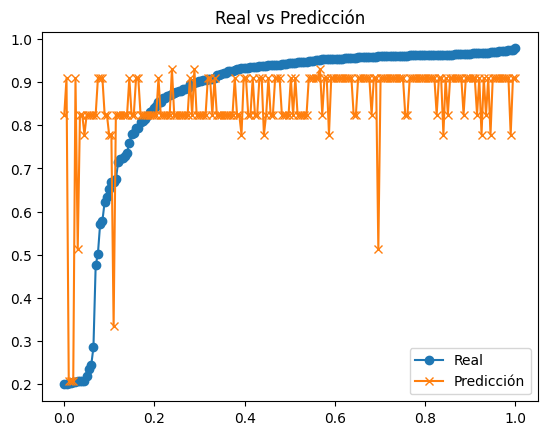

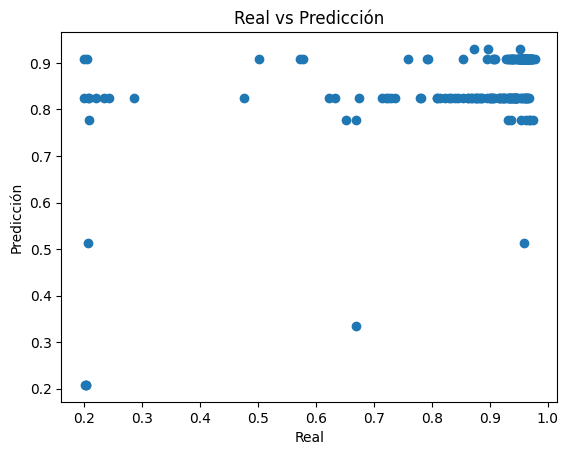

Pearson: 0.4884, Spearman: 0.4673


In [786]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# Bosques aleatorios

In [787]:
from sklearn.ensemble import RandomForestRegressor

In [788]:
# lee el df
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar modelo
model = RandomForestRegressor(random_state=seed, n_estimators=500, max_depth=6)

model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

Mean Absolute Error:  0.10473894972351418
R2:  0.3270485643049539


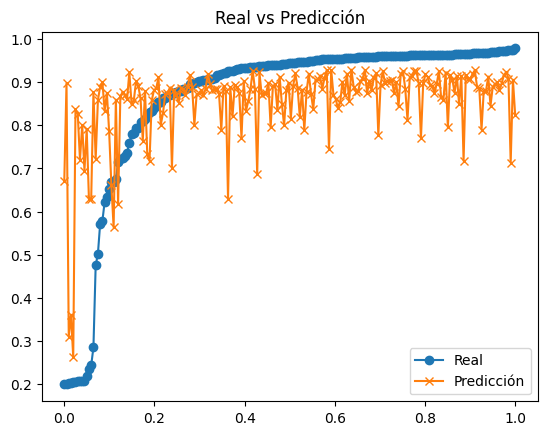

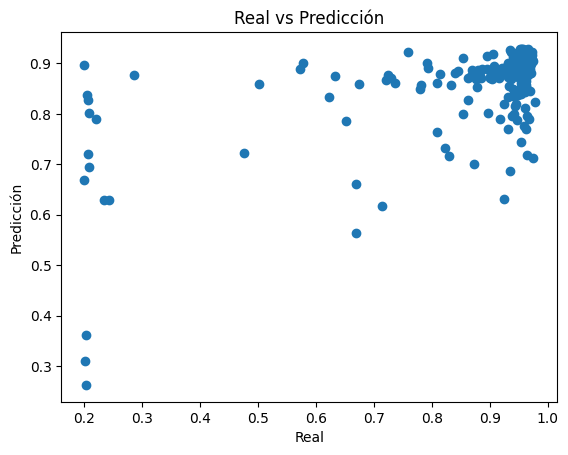

Pearson: 0.5826, Spearman: 0.4470


In [789]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# XGBRegressor

In [790]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
# Leer el DataFrame
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables (expandir listas en columnas)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Escalar características (opcional, XGBoost maneja datos sin escalar, pero ayuda en algunos casos)
scaler_X = MinMaxScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Crear y entrenar el modelo XGBoost
model = XGBRegressor(
    n_estimators=500,      # Número de árboles (boosting rounds)
    learning_rate=0.005,     # Tasa de aprendizaje
    max_depth=4,           # Profundidad máxima de los árboles
    random_state=seed, 
    objective='reg:pseudohubererror',  # Objetivo de regresión
)
model.fit(X_train_scaled, y_train)

# Predecir
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 0.08657365529401469
R² Score: 0.29124083567538106


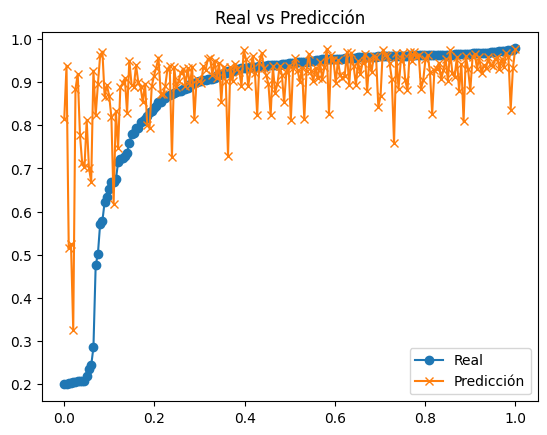

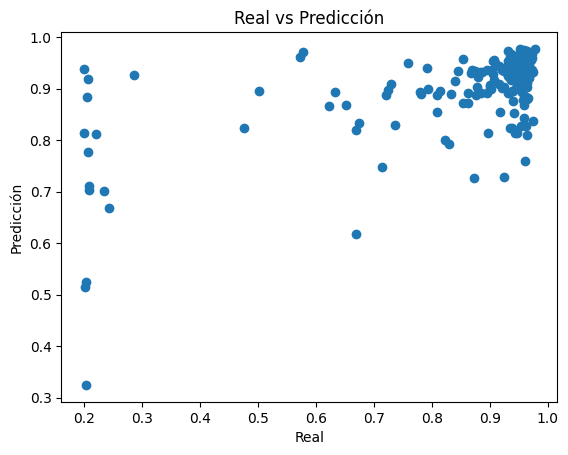

Pearson: 0.6021, Spearman: 0.4574


In [791]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

## OPtuna con XGBRegressor

In [ ]:
import ast
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# 1. Lee tus datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# 2. Split train/valid fijo para evaluación en cada trial
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Función objetivo multi-objetivo
def objective(trial):
    # Espacio de búsqueda
    params = {
        "n_estimators":      trial.suggest_int("n_estimators",      100, 1000),
        "learning_rate":     trial.suggest_float("learning_rate",   0.001, 0.1, log=True),
        "max_depth":         trial.suggest_int("max_depth",           3,    10),
        "subsample":         trial.suggest_float("subsample",         0.5,   1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.5,   1.0),
        "gamma":             trial.suggest_float("gamma",              0.0,   5.0),
        "reg_alpha":         trial.suggest_float("reg_alpha",          0.0,   5.0),
        "reg_lambda":        trial.suggest_float("reg_lambda",         0.0,   5.0),
        "random_state":      42,
        "objective":         "reg:squarederror",
        "verbosity":         0,
        "n_jobs":           -1
    }

    # Entrena en train, evalúa en validación
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Predice en validación
    preds = model.predict(X_valid)

    # 1) error
    mae = mean_absolute_error(y_valid, preds)

    # 2) Pearson (optuna maximizará)
    # scipy.stats.pearsonr devuelve (corr, p-value)
    corr, _ = pearsonr(y_valid, preds)
    corr = corr if np.isnan(corr) else corr

    # Retornamos (pearson, rmse)
    return corr, mae

# 4. Crea estudio multi-objetivo
study = optuna.create_study(
    directions=["maximize", "minimize"],
    study_name="xgb_reg_pearson_rmse"
)

# 5. Corre la optimización
study.optimize(objective, n_trials=5000)

# 6. Imprime el frente de Pareto
print("▶ Número de trials:", len(study.trials))
print("▶ Frente de Pareto (Pearson ↑, MAE ↓):")
for t in study.best_trials:
    corr, rmse = t.values
    print(f"  Trial #{t.number:02d}: Pearson={corr:.4f}, MAE={rmse:.4f}")
    for k, v in t.params.items():
        print(f"     • {k}: {v}")


[I 2025-05-11 20:48:41,388] A new study created in memory with name: xgb_reg_pearson_rmse
C:\Users\Jafet\AppData\Local\Temp\ipykernel_24904\3516500083.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_valid, preds)
[W 2025-05-11 20:48:41,441] Trial 0 failed with parameters: {'n_estimators': 186, 'learning_rate': 0.018447441655350033, 'max_depth': 6, 'subsample': 0.7034008618705176, 'colsample_bytree': 0.6385516727021263, 'gamma': 4.886199252819584, 'reg_alpha': 3.3765905341435887, 'reg_lambda': 0.15443482946996823} because of the following error: The value nan is not acceptable.
[W 2025-05-11 20:48:41,442] Trial 0 failed with value (np.float64(nan), 0.12154001726077333).
C:\Users\Jafet\AppData\Local\Temp\ipykernel_24904\3516500083.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_valid, preds)
[W 2025-05-11 20:48:41,521] Trial 1 failed with

▶ Número de trials: 1000
▶ Frente de Pareto (Pearson ↑, MAE ↓):
  Trial #496: Pearson=0.7292, MAE=0.0835
     • n_estimators: 232
     • learning_rate: 0.017883416097781147
     • max_depth: 10
     • subsample: 0.9906107522838371
     • colsample_bytree: 0.9407068150356985
     • gamma: 0.07852116979904067
     • reg_alpha: 0.059183527020660875
     • reg_lambda: 0.9066369628477805
  Trial #681: Pearson=0.7321, MAE=0.0836
     • n_estimators: 770
     • learning_rate: 0.017883416097781147
     • max_depth: 10
     • subsample: 0.9906107522838371
     • colsample_bytree: 0.9407068150356985
     • gamma: 0.07852116979904067
     • reg_alpha: 0.059183527020660875
     • reg_lambda: 0.6866577604274926
  Trial #794: Pearson=0.7321, MAE=0.0836
     • n_estimators: 857
     • learning_rate: 0.017883416097781147
     • max_depth: 10
     • subsample: 0.9906107522838371
     • colsample_bytree: 0.9407068150356985
     • gamma: 0.07852116979904067
     • reg_alpha: 0.059183527020660875
     • r

Replicación

In [799]:
# 1. Lee tus datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# 2. Split train/valid (fijo)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Recorre el frente de Pareto
print("Evaluando el frente de Pareto:")
for trial in study.best_trials:
    print(f"\n▶ Trial #{trial.number}:")
    # 4. Extrae los parámetros de este trial
    params = trial.params.copy()
    #   (si quieres, puedes fijar aquí objective / verbosity / n_jobs)
    params.update({
        "objective": "reg:squarederror",
        "verbosity": 0,
        "n_jobs": -1
    })

    # 5. Crea y entrena el modelo
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # 6. Predice y calcula métricas
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    r2  = r2_score(y_valid, y_pred)

    # 7. Imprime resultados
    print(f"   MAE = {mae:.4f}")
    print(f"   R²  = {r2:.4f}")
    
    break

Evaluando el frente de Pareto:

▶ Trial #496:
   MAE = 0.0847
   R²  = 0.4733


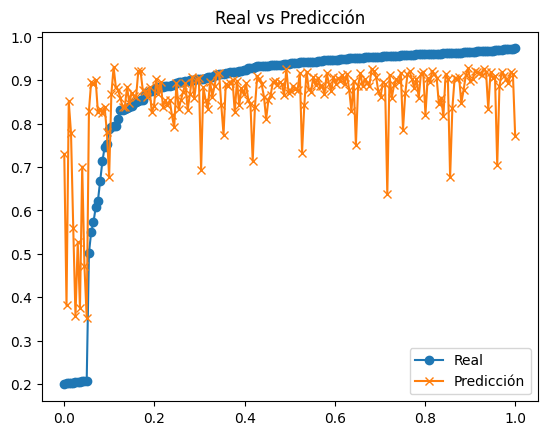

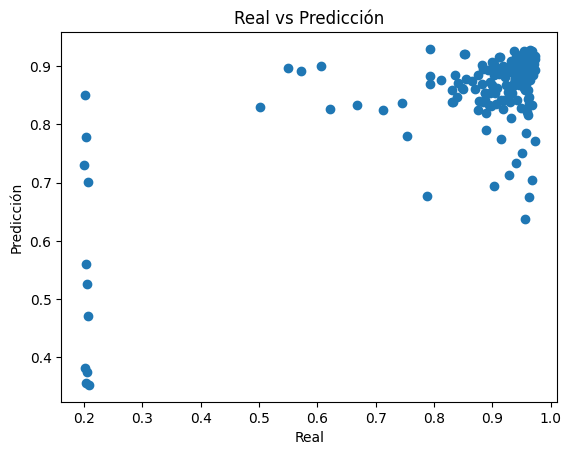

Pearson: 0.7202, Spearman: 0.4671


In [800]:
# Grafica de la predicción y la realidad
paint_results(y_valid, y_pred, order=True)
paint_real_vs_pred(y_valid, y_pred)

# Extra trees

In [795]:
from sklearn.ensemble import ExtraTreesRegressor

# Leer el DataFrame
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables (expandir listas en columnas)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Modelo Extra Trees para regresión
model = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=seed,
    n_jobs=-1
)

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 0.1163813046461462
R² Score: 0.31421337838654206


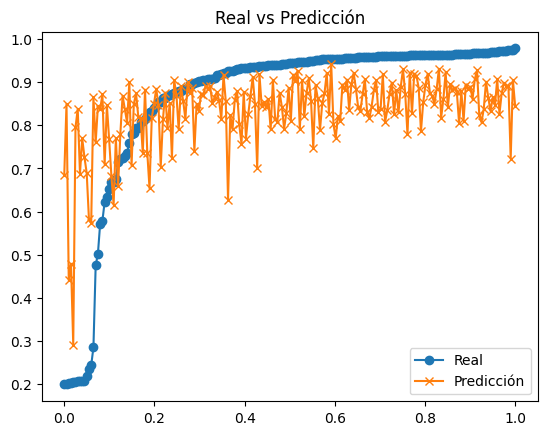

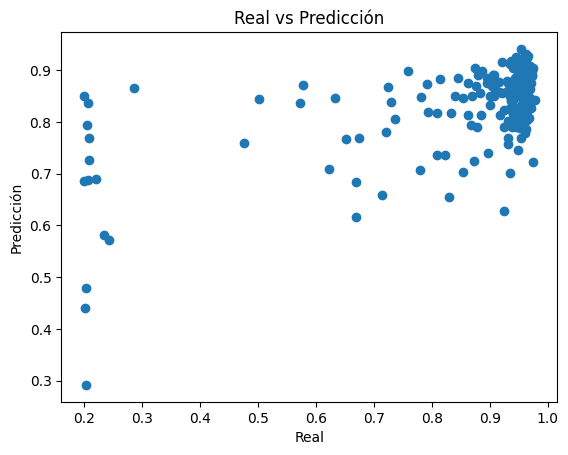

Pearson: 0.6031, Spearman: 0.4217


In [796]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# Perceptrón multicapa

In [797]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Definir la red neuronal corregida
class MLP(nn.Module):
  def __init__(self, input_dim):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Dropout(0.4),
      
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(0.3),
      
      nn.Linear(64, 1)
    )
  
  def forward(self, x):
    return self.model(x)

# Leer y preparar los datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["val_iou"].to_numpy()

# Escalar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Inicializar modelo, pérdida y optimizador
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reducir learning rate

# Entrenamiento
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:  # Mini-lotes
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {total_loss / len(train_loader)}")

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 0 - Loss: 0.2736743190417103
Epoch 10 - Loss: 0.06943902895584994
Epoch 20 - Loss: 0.059878493421802334
Epoch 30 - Loss: 0.05567730356957398
Epoch 40 - Loss: 0.049157267984221965
Epoch 50 - Loss: 0.0456381293342394
Epoch 60 - Loss: 0.04275160980429135
Epoch 70 - Loss: 0.03887226359516967
Epoch 80 - Loss: 0.03764608937005202
Epoch 90 - Loss: 0.032000379801234775
MAE: 0.1360, R²: 0.0050


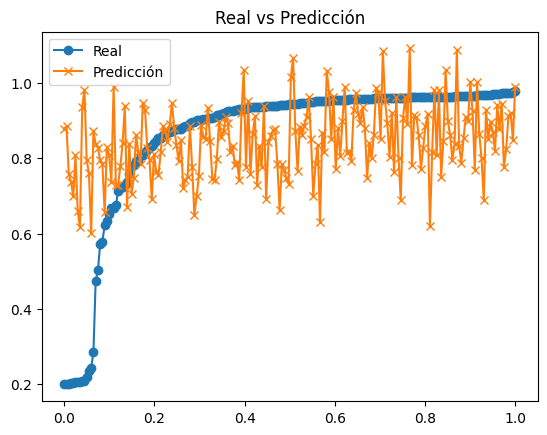

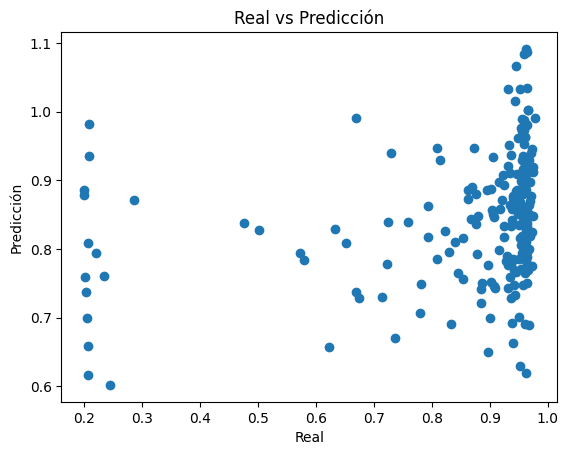

Pearson: 0.2533, Spearman: 0.3219


In [798]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)

y_test = y_test.flatten()
y_pred = y_pred.flatten()
# Grafica de la predicción y la realidad
plt.scatter(y_test, y_pred, marker="o")
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")
plt.show()
# linealidad
pearson = pearsonr(y_test, y_pred)[0]
spearman = spearmanr(y_test, y_pred)[0]
print(f"Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")